## Parts of Speech Tagging & Named Entity Recognition

In [ ]:
# This loads spacy module
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
# This line parses the sentence into a list of tuples that contain POS
sentence = 'London is the capital and most populous city of England.'
sentence_nlp = nlp(sentence)
print([(token.text, token.pos_) for token in sentence_nlp])

[('London', 'PROPN'), ('is', 'AUX'), ('the', 'DET'), ('capital', 'NOUN'), ('and', 'CCONJ'), ('most', 'ADV'), ('populous', 'ADJ'), ('city', 'NOUN'), ('of', 'ADP'), ('England', 'PROPN'), ('.', 'PUNCT')]


In [ ]:
# Dependency parsing of the sentence
from spacy import displacy
displacy.render(sentence_nlp, jupyter=True,
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

In [ ]:
# Access NAMED ENTITIES using the 'ents' attribute
named_entities = sentence_nlp.ents
print(named_entities)

(London, England)


In [ ]:
# print named entities in article
print([(word.text, word.label_) for word in sentence_nlp.ents])

# visualize named entities
from spacy import displacy
displacy.render(sentence_nlp, style='ent', jupyter=True)

[('London', 'GPE'), ('England', 'GPE')]


# Word Cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import re
import unicodedata

In [ ]:
# Loading pre-collected Reddit comments
url = 'https://raw.githubusercontent.com/EunCheolChoi0123/COMM557Tutorial/refs/heads/main/Tutorial%203%20Reddit%20Scraper%20and%20Network/datascience-new-comment.csv'
df  = pd.read_csv(url)
df = df[~df.body.isna()]

df['body'] = df['body'].astype('str')
df['body']

,body
0,This one will give you a solid starting point ...
1,I’m an MCA student who just started this Septe...
2,"Oh yeah, that's a really good collection. It's..."
3,There is a dedicated thread you can use for th...
4,Thanks
...,...
104,"Thanks, this is good advice"
105,"I'd say hindrance. The data we have is OK, the..."
106,"Thanks, why?"
107,"Once you go into consultancy, it's very diffic..."


In [ ]:
import nltk
from nltk import ToktokTokenizer
import spacy
import re, unicodedata


nlp = spacy.load('en_core_web_sm')

### Run this the first time
nltk.download('stopwords')
nltk.download('punkt')

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# choose functions that suit your neeeds

# Removing stopwords: you can customize the list
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Stripping HTML links using Regex - other use cases might include emails, phone numbers, etc.
def strip_links(text: str) -> str:
    SIMPLE_LINK_RE = re.compile(r'https?://\S+|www\.\S+')
    return SIMPLE_LINK_RE.sub(' ', text)

# Removing non-alphabetic/numeric characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# Stemming
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

# Lemmatizing
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# filtering in only noun using spacy module
def noun_only(text, include_proper=True, lowercase=True, unique=False):
    if not isinstance(text, str) or not text.strip():
        return ""
    doc = nlp(text)
    keep_pos = {"NOUN", "PROPN"} if include_proper else {"NOUN"}
    out = [
        (tok.text.lower() if lowercase else tok.text)
        for tok in doc
        if tok.pos_ in keep_pos and tok.is_alpha and not tok.is_stop
    ]
    if unique:
        out = list(dict.fromkeys(out))
    return " ".join(out)


In [ ]:
def process_posts(post):
    post = remove_stopwords(post)
    post = strip_links(post)
    post = remove_special_characters(post)
    post = lemmatize_text(post)
    post = noun_only(post)

    return post

df.loc[:, 'body'] = df.body.apply(process_posts)

In [ ]:
df.body[0]

'point pivot'

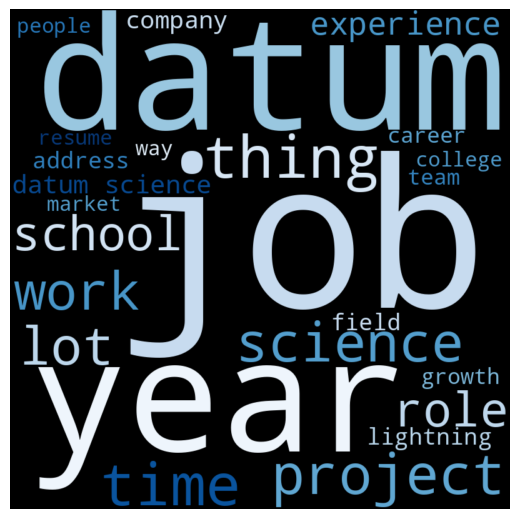

In [ ]:
# merge all preprocessed content into a single string
text = ' '.join(df.body.tolist()).lower()

# create the wordcloud object
wordcloud = WordCloud(width = 800, height = 800,
                #background_color ='white',
                stopwords = STOPWORDS,
                max_words=25,
                colormap='Blues', # Blues
                collocations = True,
                prefer_horizontal=1.0,
                min_font_size = 10).generate(text)

# plot word cloud
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.margins(x=0, y=0)
plt.axis("off")
plt.tight_layout(pad = 0)

# Semantic Network

In [ ]:
# In the colab environment, after you install gensim, you need to restart the session
!pip install vaderSentiment
!pip install gensim

In [ ]:
import pandas as pd
import spacy
from datetime import datetime
import re
import string
from collections import Counter
import itertools
import networkx as nx
import unicodedata
import random
from gensim import corpora
import nltk
from nltk import ToktokTokenizer
import matplotlib.pyplot as plt

In [ ]:
# Read the file
url = 'https://raw.githubusercontent.com/EunCheolChoi0123/COMM557Tutorial/refs/heads/main/Tutorial%203%20Reddit%20Scraper%20and%20Network/datascience-new-comment.csv'
df  = pd.read_csv(url)
df = df[~df.body.isna()]

In [ ]:
nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('punkt')

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

# choose functions that suit your neeeds

# Removing stopwords: you can customize the list
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Stripping HTML links using Regex - other use cases might include emails, phone numbers, etc.
def strip_links(text: str) -> str:
    SIMPLE_LINK_RE = re.compile(r'https?://\S+|www\.\S+')
    return SIMPLE_LINK_RE.sub(' ', text)

# Removing non-alphabetic/numeric characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# Stemming
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

# Lemmatizing
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# filtering in only noun using spacy module
def noun_only(text, include_proper=True, lowercase=True, unique=False):
    if not isinstance(text, str) or not text.strip():
        return ""
    doc = nlp(text)
    keep_pos = {"NOUN", "PROPN"} if include_proper else {"NOUN"}
    out = [
        (tok.text.lower() if lowercase else tok.text)
        for tok in doc
        if tok.pos_ in keep_pos and tok.is_alpha and not tok.is_stop
    ]
    if unique:
        out = list(dict.fromkeys(out))
    return " ".join(out)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Create corupus of all words
words_corpus = []
for elem in df.body:
    words_corpus.append(elem.lower().split())
print(len(words_corpus))

dictionary = corpora.Dictionary(words_corpus)
print(len(dictionary))

109
2018


In [ ]:
# This function takes in each preprocessed comment, and return edges as tuples when within k distance
def window_pairs(tokens, k=3):
    out = []
    n = len(tokens)
    for i in range(n):
        for j in range(i+1, min(i+k, n)):
            a, b = tokens[i], tokens[j]
            if a != b:
                out.append(tuple(sorted((a, b))))
    return out

df["tokens"] = df["body"].str.split()
df["win_tups"] = df["tokens"].apply(window_pairs, k=3)
win_counts = Counter(p for ps in df["win_tups"] for p in ps)


In [ ]:
# Let's use only the 100 most common edges here
word_edges = win_counts.most_common(100)
word_edges = [(w[0][0], w[0][1], w[1] ) for w in word_edges]

In [ ]:
# Weighted undirected graph
G = nx.Graph()
G.add_weighted_edges_from(word_edges)

In [ ]:
# Remove self-loop
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
# Let's only visualize the largest component
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
largest_component = connected_components[0]
G = G.subgraph(largest_component)

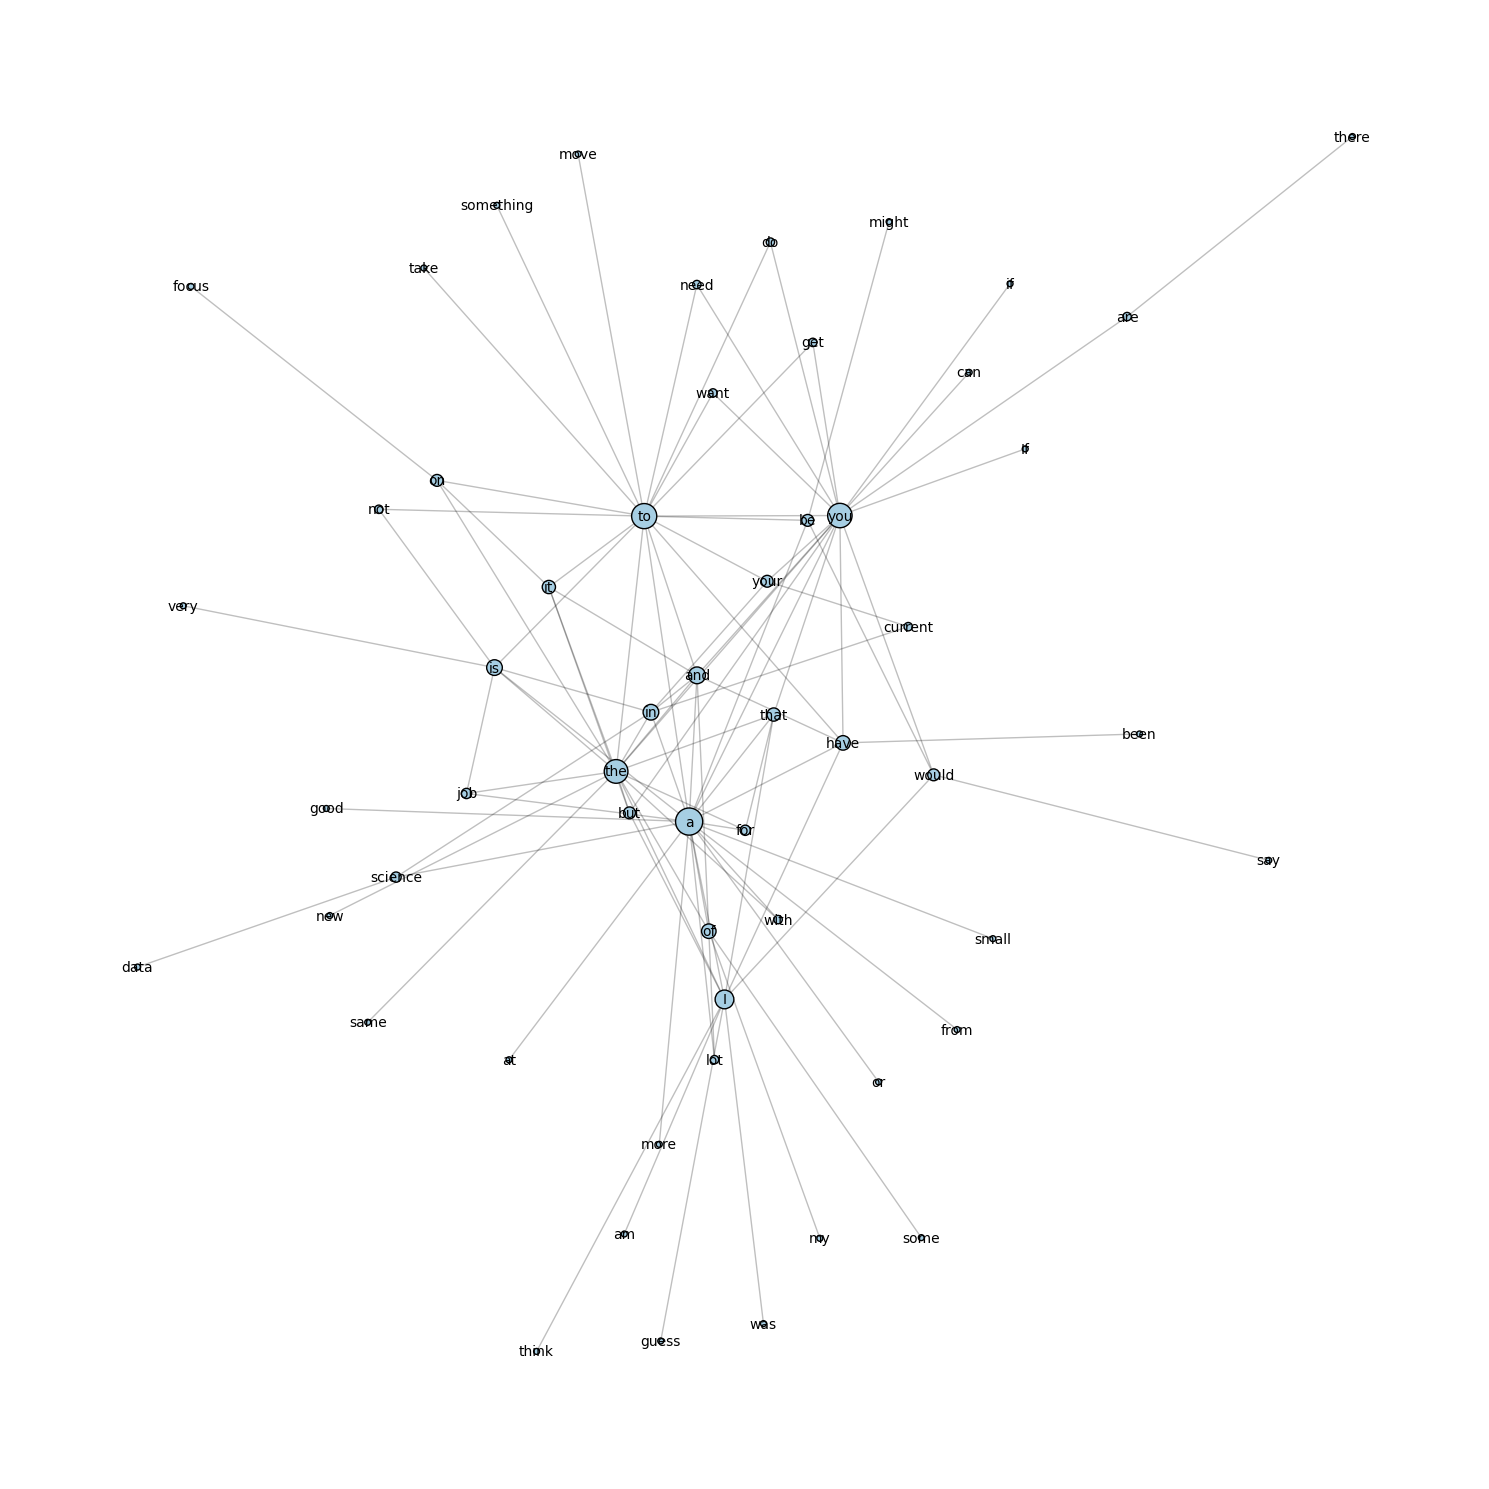

In [ ]:
# Scale node size based on degree centrality
degree_centrality = nx.degree_centrality(G)
scaled_degree_centrality = {node: deg * 1000 for node, deg in degree_centrality.items()}  # Scale it up for visualization

# Lighter node colors
node_colors = ['#a6cee3' for _ in G.nodes()]

# Node positions
pos = nx.spring_layout(G, seed=200)

plt.figure(figsize=(15, 15))  # Increase the figure size for a larger plot

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)

# Draw nodes with lighter colors and scaled sizes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=list(scaled_degree_centrality.values())).set_edgecolor('black')

# Add standout labels to the nodes
labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

# Show the graph
plt.tight_layout()
plt.axis("off")
plt.show()
